In [1]:
import pandas as pd
import numpy as np
import LSTM_preprocessing as pre
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
#import mysql.connector
#from mysql.connector import Error
import warnings
warnings.filterwarnings("ignore")

In [2]:
connection = pre.connect_to_database()

if connection:
    # Query merged data
    merged_df = pre.query_merged_crypto_data(connection)

    if merged_df is not None and not merged_df.empty:
        # Display first few rows of the DataFrame
        print("\nMerged DataFrame:")
        print(merged_df.head())

    else:
        print("\nNo data found after merging.")

    # Close the connection
    pre.query_quit(connection)

Connected to MySQL database, MySQL Server version:  8.0.39

Merged DataFrame:
   id crypto_symbol                date lending_rate borrowing_rate  \
0   1       BATUSDT 2020-12-02 14:00:00   -50.000000     -50.000000   
1   2       BATUSDT 2020-12-02 15:00:00   -50.000000     -50.000000   
2   3       BATUSDT 2020-12-02 16:00:00   -50.000000     -50.000000   
3   4       BATUSDT 2020-12-02 17:00:00   -50.000000     -50.000000   
4   5       BATUSDT 2020-12-02 18:00:00   -50.000000     -50.000000   

  utilization_rate stable_borrow_rate crypto_symbol                date  high  \
0       -50.000000           0.030000       BATUSDT 2020-12-02 14:00:00  0.24   
1       -50.000000           0.030000       BATUSDT 2020-12-02 15:00:00  0.24   
2         0.013598           0.030000       BATUSDT 2020-12-02 16:00:00  0.24   
3         0.014834           0.030000       BATUSDT 2020-12-02 17:00:00  0.24   
4         0.014834           0.030000       BATUSDT 2020-12-02 18:00:00  0.25   

    low 

In [3]:
# merged_df = pd.read_csv("E:\Funding_rate_Aave\merged_crypto_data.csv")

# Drop the second occurrence of a specific column
merged_df = merged_df.loc[:, ~merged_df.columns.duplicated()]
# data without NA rows if we needed 
filtered_df = merged_df[(merged_df['borrowing_rate'] != -50)&(merged_df['lending_rate'] != -50)&(merged_df['utilization_rate'] != -50)]
filtered_df.reset_index(inplace=True, drop=True)
# date formatting
filtered_df['date'] = pd.to_datetime(filtered_df['date'])
# taking the columns we want and converting them to floats
filtered_df = filtered_df[['crypto_symbol', 'date', 'lending_rate',	'borrowing_rate','utilization_rate','close', 'volume']]
filtered_df[['lending_rate',	'borrowing_rate','utilization_rate','close', 'volume']] = filtered_df[['lending_rate','borrowing_rate','utilization_rate','close', 'volume']].astype(float)


In [4]:
# Initialize empty lists to store aggregated inputs and targets
all_inputs = []
all_targets = []

# looping through symbols
symbols = filtered_df['crypto_symbol'].unique()
s = symbols[0]

sim_df = filtered_df
sim_df.reset_index(inplace=True, drop=True)
print(len(sim_df))
# First Loop: Calculate intervals for each column without modifying the DataFrame

# getting the returns
reduced_df = sim_df.copy()
reduced_df['returns'] = pre.calculate_hourly_returns(reduced_df, 'date', 'close')
reduced_df = reduced_df[reduced_df['returns'].notna()]
print('rows with valid returns:', len(reduced_df))
reduced_df.reset_index(inplace=True, drop=True)

intervals = {}  
for i in symbols:
    # Filter rows where 'crypto_symbol' == i
    df_filtered = reduced_df[reduced_df['crypto_symbol'] == i]
    
    intervals[i] = {} 
    
    # Calculate IQR bounds for the filtered rows
    for column in ['lending_rate', 'borrowing_rate', 'utilization_rate']:
        lower, upper = pre.calculate_iqr_bounds(df_filtered[column])
        intervals[i][column] = {'lower_bound': lower, 'upper_bound': upper}
    
    # Filter rows based on the pre-calculated intervals
    for column in ['lending_rate', 'borrowing_rate', 'utilization_rate']:
        lower_bound = intervals[i][column]['lower_bound']
        upper_bound = intervals[i][column]['upper_bound']
        # Apply filtering on the filtered DataFrame
        df_filtered = df_filtered[(df_filtered[column] > lower_bound) & (df_filtered[column] < upper_bound)]
    
    # Update the reduced_df with the filtered results for this 'crypto_symbol'
    reduced_df = reduced_df[reduced_df['crypto_symbol'] != i]  # Remove rows for the current symbol
    reduced_df = pd.concat([reduced_df, df_filtered])  # Add back the filtered rows

reduced_df.reset_index(inplace=True, drop=True)


# MinMax scaling
scaler = MinMaxScaler(feature_range=(0, 1))  # Default range is (0, 1)

scaled_df = reduced_df.copy()
scaled_df['lending_rate'] = scaler.fit_transform(reduced_df[['lending_rate']])
scaled_df['borrowing_rate'] = scaler.fit_transform(reduced_df[['borrowing_rate']])
scaled_df['utilization_rate'] = scaler.fit_transform(reduced_df[['utilization_rate']])
scaled_df['close'] = scaler.fit_transform(reduced_df[['close']])
scaled_df['volume'] = scaler.fit_transform(reduced_df[['volume']])
scaled_df['returns'] = scaler.fit_transform(reduced_df[['returns']])

inputs, targets = pre.extract_valid_windows(
     scaled_df,
     'date', 
     48, 24, 
     ['lending_rate', 'borrowing_rate', 'utilization_rate', 'returns', 'volume'], 
     ['lending_rate', 'borrowing_rate']
     )


print('input size', inputs.shape)
print('output size', targets.shape)

# Count NaNs in input and output
input_nans = np.isnan(inputs).sum()
output_nans = np.isnan(targets).sum()

print(f"Number of NaNs in input: {input_nans}")
print(f"Number of NaNs in output: {output_nans}")


418650
rows with valid returns: 411877
input size (86797, 48, 5)
output size (86797, 24, 2)
Number of NaNs in input: 0
Number of NaNs in output: 0


In [ ]:
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(inputs, targets, test_size=0.2, random_state=42)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)


# 3. establish the 
model = Sequential([
    LSTM(48, 
         activation='tanh', 
         input_shape=(inputs.shape[1], inputs.shape[2]), 
         return_sequences=True
         ),
    Dropout(0.2),
    LSTM(48, activation='tanh'),
    Dropout(0.2),
    Dense(targets.shape[1] * targets.shape[2]), 
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# 4. train model
history = model.fit(X_train, y_train.reshape(y_train.shape[0], -1), epochs=20, batch_size=32, validation_split=0.2)

# 5. validate the model
test_loss, test_mae = model.evaluate(X_test, y_test.reshape(y_test.shape[0], -1))
print(f"Test Loss: {test_loss}, Test MAE: {test_mae}")

# 6. calculate predictions
predictions = model.predict(X_test)





(69437, 48, 5)
(17360, 48, 5)
(69437, 24, 2)
(17360, 24, 2)
Epoch 1/20
1736/1736 [==============================] - 14s 7ms/step - loss: 4.3602e-04 - mae: 0.0092 - val_loss: 1.5375e-04 - val_mae: 0.0044
Epoch 2/20
1736/1736 [==============================] - 11s 7ms/step - loss: 2.3063e-04 - mae: 0.0065 - val_loss: 1.5397e-04 - val_mae: 0.0034
Epoch 3/20
1736/1736 [==============================] - 11s 7ms/step - loss: 2.0867e-04 - mae: 0.0061 - val_loss: 1.5680e-04 - val_mae: 0.0049
Epoch 4/20
1736/1736 [==============================] - 11s 7ms/step - loss: 2.0622e-04 - mae: 0.0059 - val_loss: 1.5425e-04 - val_mae: 0.0035
Epoch 5/20
1736/1736 [==============================] - 11s 7ms/step - loss: 2.0134e-04 - mae: 0.0059 - val_loss: 2.1663e-04 - val_mae: 0.0062
Epoch 6/20
1736/1736 [==============================] - 12s 7ms/step - loss: 1.9550e-04 - mae: 0.0058 - val_loss: 1.7217e-04 - val_mae: 0.0046
Epoch 7/20
1736/1736 [==============================] - 12s 7ms/step - loss: 1.943

In [6]:
predictions.shape

(17360, 48)

In [7]:
# Split into two separate outputs
# lending_rate
output_1 = targets[:, :, 0].reshape(targets.shape[0], targets.shape[1], 1)  # First column
# borrowing rate
output_2 = targets[:, :, 1].reshape(targets.shape[0], targets.shape[1], 1)  # Second column
# lets predict seperatly


Training data shape: (52077, 48, 5)
Validation data shape: (17360, 48, 5)
Test data shape: (17360, 48, 5)
Training labels shape: (52077, 24, 1)
Validation labels shape: (17360, 24, 1)
Test labels shape: (17360, 24, 1)
Epoch 1/30
521/521 [==============================] - 6s 8ms/step - loss: 5.9244e-04 - mae: 0.0098 - val_loss: 1.3581e-04 - val_mae: 0.0029
Epoch 2/30
521/521 [==============================] - 4s 7ms/step - loss: 2.5966e-04 - mae: 0.0064 - val_loss: 1.2482e-04 - val_mae: 0.0029
Epoch 3/30
521/521 [==============================] - 4s 7ms/step - loss: 2.2463e-04 - mae: 0.0057 - val_loss: 1.1988e-04 - val_mae: 0.0021
Epoch 4/30
521/521 [==============================] - 4s 7ms/step - loss: 2.1030e-04 - mae: 0.0053 - val_loss: 1.4280e-04 - val_mae: 0.0057
Epoch 5/30
521/521 [==============================] - 4s 7ms/step - loss: 2.0212e-04 - mae: 0.0052 - val_loss: 1.2522e-04 - val_mae: 0.0033
Epoch 6/30
521/521 [==============================] - 4s 7ms/step - loss: 1.9988e-

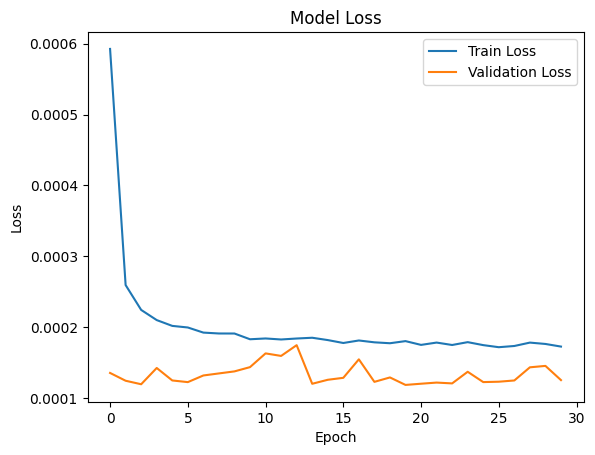

543/543 [==============================] - 2s 2ms/step


In [8]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

def train_and_evaluate(inputs, outputs, test_size=0.2, valid_size=0.25, random_state=42, epochs=30, batch_size=100):
    # Clearing the TensorFlow session to ensure the model starts with fresh weights and biases
    tf.keras.backend.clear_session()

    # Setting the seed for reproducibility
    np.random.seed(random_state)
    tf.random.set_seed(random_state)

    # Splitting the data into train+validation and test sets
    X_train_valid, X_test, y_train_valid, y_test = train_test_split(
        inputs, outputs, test_size=test_size, random_state=random_state)

    # Splitting the train+validation set into separate training and validation sets
    X_train, X_valid, y_train, y_valid = train_test_split(
        X_train_valid, y_train_valid, test_size=valid_size, random_state=random_state)

    # Printing the shapes of the datasets
    print("Training data shape:", X_train.shape)
    print("Validation data shape:", X_valid.shape)
    print("Test data shape:", X_test.shape)
    print("Training labels shape:", y_train.shape)
    print("Validation labels shape:", y_valid.shape)
    print("Test labels shape:", y_test.shape)

    # Model definition
    model = Sequential([
        LSTM(48, activation='tanh', input_shape=(inputs.shape[1], inputs.shape[2]), return_sequences=True),
        Dropout(0.2),
        LSTM(48, activation='tanh'),
        Dropout(0.2),
        Dense(outputs.shape[1] * outputs.shape[2]),
    ])

    # Compiling the model
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])

    # Training the model
    history = model.fit(
        X_train, y_train.reshape(y_train.shape[0], -1),
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(X_valid, y_valid.reshape(y_valid.shape[0], -1))
    )

    # Plotting training and validation loss
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()

    # Making predictions on the test set
    test_predictions = model.predict(X_test)
    return y_test, test_predictions


y_test, test_predictions = train_and_evaluate(inputs, output_1)


In [29]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, classification_report


def rate_growth(data, prediction, threshold_factor=0.05):
    # Calculate changes for data
    changes_data = data[:, 23, 0] - data[:, 0, 0]
    std_data = np.std(changes_data)
    threshold_data = threshold_factor * std_data

    # Classify growth for data
    growth_data = []
    for change in changes_data:
        if change > 0.5*threshold_data:
            growth_data.append(1)
        elif change < -0.5*threshold_data:
            growth_data.append(-1)
        else:
            growth_data.append(0)

    # Calculate changes for prediction
    changes_prediction = prediction[:, 23] - prediction[:, 0]
    std_prediction = np.std(changes_prediction)
    threshold_prediction = threshold_factor * std_prediction

    # Classify growth for prediction
    growth_prediction = []
    for change in changes_prediction:
        if change > threshold_data:
            growth_prediction.append(1)
        elif change < -threshold_data:
            growth_prediction.append(-1)
        else:
            growth_prediction.append(0)

    return growth_data, growth_prediction

def classification_metrics(y_true, y_pred):
    # Calculate the confusion matrix
    conf_matrix = confusion_matrix(y_true, y_pred)
    
    # Visualization of the confusion matrix using Seaborn
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['-1', '0', '1'], yticklabels=['-1', '0', '1'])
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()
    
    # Calculate metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='macro', zero_division=0)
    recall = recall_score(y_true, y_pred, average='macro', zero_division=0)
    f1 = f1_score(y_true, y_pred, average='macro', zero_division=0)
    
    # Printing classification metrics
    print("Classification Metrics:")
    print("Accuracy: {:.2f}".format(accuracy))
    print("Precision: {:.2f}".format(precision))
    print("Recall: {:.2f}".format(recall))
    print("F1 Score: {:.2f}".format(f1))
    
    # Detailed classification report
    print("\nDetailed Classification Report:")
    print(classification_report(y_true, y_pred, target_names=['-1', '0', '1']))

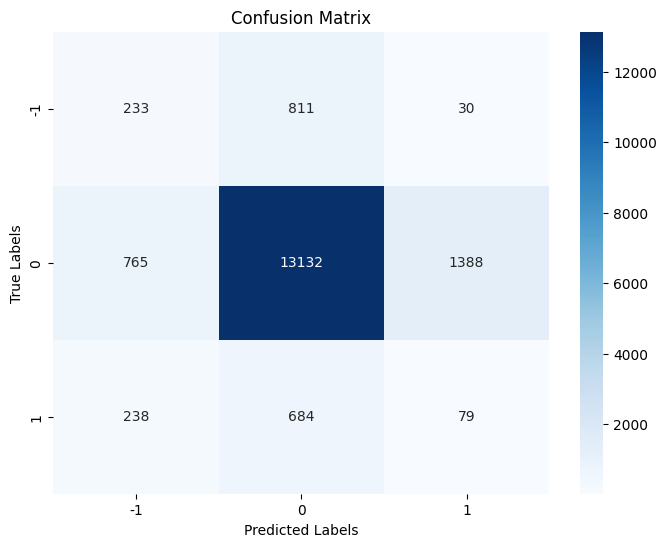

Classification Metrics:
Accuracy: 0.77
Precision: 0.38
Recall: 0.39
F1 Score: 0.38

Detailed Classification Report:
              precision    recall  f1-score   support

          -1       0.19      0.22      0.20      1074
           0       0.90      0.86      0.88     15285
           1       0.05      0.08      0.06      1001

    accuracy                           0.77     17360
   macro avg       0.38      0.39      0.38     17360
weighted avg       0.81      0.77      0.79     17360



In [33]:
growth_data, growth_prediction = rate_growth(y_test, test_predictions, threshold_factor=0.08)
classification_metrics(growth_data, growth_prediction)